# Activity: Explore Customer Spending Preference Dataset
Let's load and explore a [customer spending preferences dataset from Kaggle](https://www.kaggle.com/code/heeraldedhia/kmeans-clustering-for-customer-data?select=Mall_Customers.csv). This dataset was created learning customer segmentation concepts, known as [market basket analysis](https://en.wikipedia.org/wiki/Market_basket). We'll load the data, explore the fields, and do some basic exploration to see what's in the dataset.

## Setup
We set up the computational environment by including the `Include.jl` file and loading any needed resources, e.g., a sample dataset, to cluster.
* __Include__: The [include command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc.
* __Documentation__: For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLDataScienceMachineLearningPackage.jl documentation](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). 

In [3]:
include("Include.jl")

### Data
We load the dataset [using the `MyKaggleCustomerSpendingDataset() method`](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/data/#VLDataScienceMachineLearningPackage.MyKaggleCustomerSpendingDataset) exported by the [VLDataScienceMachineLearningPackage.jl package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). This method returns the raw data [as a `DataFrame` instance](https://github.com/JuliaData/DataFrames.jl).

We'll save the raw data in the `originaldataset::DataFrame` variable:

In [5]:
originaldataset = MyKaggleCustomerSpendingDataset()

Row,id,gender,age,income,spendingscore
,Int64,String7,Int64,Int64,Int64
1,1,Male,19,15,39
2,2,Male,21,15,81
3,3,Female,20,16,6
4,4,Female,23,16,77
5,5,Female,31,17,40
6,6,Female,22,17,76
7,7,Female,35,18,6
8,8,Female,23,18,94
9,9,Male,64,19,3


__Fields and records__: Let's check the number of records we have and the number and type of the fields in each record in the `originaldataset::DataFrame`. 

_Records_: Each row in the dataset holds a record, so we'll compute the number of records by computing the number of rows [using the `nrow(...)` method exported by `DataFrames.jl`](https://dataframes.juliadata.org/stable/lib/functions/#DataAPI.nrow). We'll call [the `nrow(...)` method](https://dataframes.juliadata.org/stable/lib/functions/#DataAPI.nrow) and pass the output of that command to [the Julia `println(...)` method](https://docs.julialang.org/en/v1/base/io-network/#Base.println) using [the `|>` pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping).

In [7]:
nrow(originaldataset) |> n-> println("Number of records: $(n)")

Number of records: 200


_Fields_: We can compute the number of fields on each record using [the `ncol(...)` method exported by the `DataFrames.jl` package](https://dataframes.juliadata.org/stable/lib/functions/#DataAPI.ncol). However, [the `ncol(...)` method](https://dataframes.juliadata.org/stable/lib/functions/#DataAPI.ncol) only returns the number of fields, not the fieldname or the type of data contained in the field.

In [9]:
ncol(originaldataset) |> n-> println("Number of fields: $(n)")

Number of fields: 5


_Deeper dive_: Let's explore the fields and their types using the [the `each col (...)` method](https://dataframes.juliadata.org/stable/lib/functions/#Base.eachcol) and the [the `eltype(...)` method](https://docs.julialang.org/en/v1/base/collections/#Base.eltype). 
* [The `eachcol(...)` method](https://dataframes.juliadata.org/stable/lib/functions/#Base.eachcol) provides an iterable collection over the columns (fields) while [the `eltype(...)` method](https://docs.julialang.org/en/v1/base/collections/#Base.eltype) determines the type of the data in each column (field).
* To get the names of the columns (fields), we'll use [the `names(...)` method](https://dataframes.juliadata.org/stable/lib/functions/#Base.names), which takes a DataFrame as an argument, and returns an `Array{String,1}` holding the names, where each name is a `String` type.

`Unhide` the code block below to see how we build a table using [the `pretty_table(...)` method exported by the PrettyTables.jl package](https://github.com/ronisbr/PrettyTables.jl), which lists the data about the fields and their types.

In [11]:
let

    # initialize -
    df = DataFrame(); # storage for the table data
    fieldnames = names(originaldataset); # Array of field names as Strings

    # Iterate over the collection of columns, compile data for each column
    index = 1;
    for field ∈ eachcol(originaldataset)

        df_row = (
            fieldname = fieldnames[index],
            fieldtype = eltype(field),
        ); # Store the data for a row (field) as a NamedTuple

        push!(df, df_row); # store row data in the DataFrame
        index += 1;
    end

    # display the DataFrame -
    pretty_table(df, tf = tf_simple); # tf -> table formatting, see documentation for availabe styles
end

================ ============
      fieldname   fieldtype 
         String    DataType 
================ ============
             id       Int64
         gender     String7
            age       Int64
         income       Int64
  spendingscore       Int64
================ ============


## Exploration
Now that we have the data loaded and know the number of records and the makeup of each record, let's explore the dataset to get a flavor of what's in it. We'll ask some common questions about the data, e.g., is it balanced in the categorical variables, are fields normally distributed, etc.

### Is the data gender balanced?
Gender is a [categorical field](https://en.wikipedia.org/wiki/Categorical_variable) in the original dataset. Let's remap the `gender::String7` $\in\left\{\texttt{Male},\texttt{Female}\right\}$ categorical feature to a number, i.e., let `Male = -1` and `Female = 1.` 
* _Why_? It's much easier to use numbers than categorical data when looking at (and analyzing) this data later. We'll store the revised dataset in [the `dataset::DataFrame` variable](https://github.com/JuliaData/DataFrames.jl). To do this remapping, we use [the `transform!(...)` method](https://dataframes.juliadata.org/stable/lib/functions/#DataFrames.transform!). The bang `!` character at the end of the method name is a Julia naming convention that tells the user that this method is a [mutating in-place method](https://docs.julialang.org/en/v1/manual/functions/#man-argument-passing), i.e., it doesn't return anything. Instead, it modifies its arguments in memory.
* _Note_: The original dataset did not include shoppers who identified as non-binary. Hence, we transformed the original `gender::String7` field to $\{-1,1\}$. However, if non-binary shoppers were to enter the dataset, we could map them to a different number, e.g., `0`.

In [13]:
dataset = let
    treated_dataset = copy(originaldataset);
    transform!(treated_dataset, :gender => ByRow( x-> (x=="Male" ? -1 : 1)) => :gender); # maps gender to -1,1
    treated_dataset 
end;

Next, let's compute the fraction of each gender in the data using [the `filter(...)` method](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter).
* [The `filter(...)` method](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) returns a DataFrame instance containing the records (rows) that meet some criteria, e.g., a record corresponds to a female shopper `gender = 1`. We then pass the resulting DataFrame instance to [the `nrow(...)` method](https://dataframes.juliadata.org/stable/lib/functions/#DataAPI.nrow) using [the `|>` pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping).

We save the fraction of male and female shoppers in the `f_male::Float64` and `f_female::Float64` variables, respectively.

In [15]:
f_male, f_female = let

    number_of_records = nrow(dataset); # how many total records?
    n_male = filter(:gender => x-> x == -1, dataset) |> df -> nrow(df);
    n_female = filter(:gender => x -> x == 1, dataset) |> df -> nrow(df);

    n_male/number_of_records, n_female/number_of_records
end

(0.44, 0.56)

_Does the dataset represent the population_? According to [the United States Census Bureau](https://www.census.gov/quickfacts/fact/table/US/LFE046223), female persons make up `50.5%` of the population in the United States. How does this compare to the fraction of female records in the dataset?

In [17]:
let
    reflect_society_flag = true; # assume data represents society
    reflect_society_flag = f_female ≈ 0.505 ? true : false;
    println("Data represents popultion: $(reflect_society_flag)")
end

Data represents popultion: false


### What is the distribution of a field in the dataset?
Another interesting question is whether the non-categorical data, e.g., a numerical field like `spendingscore`, is distributed in some particular way, e.g., [a Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution). One easy strategy to explore this idea is to fit the parameters of a distribution such as [a Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) using a technique such as [maximum likelihood estimation (mle)](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) and see how it compares to the data.

However, there is a technical issue with this strategy:
* _Hmmm_. The non-categorical numerical values in the dataset are all integers, not continuous floating-point values. Thus, a continuous probability distribution function (PDF) such as [a Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution) is inappropriate, as non-integer values, e.g., `50.6`, would have non-zero density. We should develop a probability mass function (PMF) instead.

Let's explore this idea. First, we'll build a continuous approximation to the data, and then we'll create a discrete model of the data. Let's begin by specifying what field we want to look at in the `field_to_look_at::Symbol` variable:

In [93]:
field_to_look_at = :age; # choose from {age,income,spendingscore}

__Continuous model__: Next, build a continuous model (using one of the models exported by [the `Distributions.jl` package](https://github.com/JuliaStats/Distributions.jl)) of the data using [the `fit_mle(...)` method exported by the `Distributions.jl` package](https://juliastats.org/Distributions.jl/stable/fit/#Distributions.fit_mle-Tuple{Any,%20Any}) and store it in the `d₁ <: ContinuousUnivariateDistribution` variable (the `<:` denotes the distribution `d₁` is a subtype of `ContinuousUnivariateDistribution`).

In [95]:
d₁ = let
    data = dataset[:,field_to_look_at]; # Get the data for your field
    d = fit_mle(Normal, data); # TODO: fit to a distribution, e.g., Normal, but could be anything
end

Normal{Float64}(μ=38.85, σ=13.934041050606966)

In [96]:
@assert typeof(d₁) <: ContinuousUnivariateDistribution; # check: User needs to select a univariate continuous distribution

`Unhide` the code block below to see how we plotted the distribution $d_{1}$ and the associated data, assuming we modeled the data using a continuous univariate distribution.
* __Summary__: Depending upon which field and distribution model you choose, you will see the model (red line) and the data (blue line) look roughly similar. For [a Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), the data and the model look approximately similar, but not exactly the same. The data has some gyrations that the model did not capture.

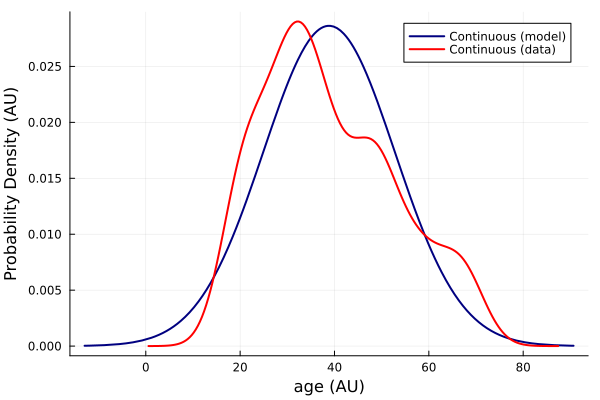

In [98]:
let
    data = dataset[:,field_to_look_at]; # Get the data for your field
    plot(d₁, c=:navy, lw=2, label="Continuous (model)")
    density!(data, c=:red, lw=2, label="Continuous (data)")
    xlabel!("$(String(field_to_look_at)) (AU)", fontsize = 18);
    ylabel!("Probability Density (AU)", fontsize=18)
end

Is the mean and standard deviation $(\mu,\sigma)$ the same between the model and the data?

In [100]:
let

    # initialize -
    data = dataset[:,field_to_look_at]; # Get the data for your field
    
    μ = mean(d₁); # what is the mean
    μ̄ = mean(data); # what is the data mean?
    σ = std(d₁);
    σ̄ = std(data);
    println("Model (μ,σ)=($(μ),$(σ)) versus data (μ̄,σ̄)=($(μ̄),$(σ̄))")
end

Model (μ,σ)=(38.85,13.934041050606966) versus data (μ̄,σ̄)=(38.85,13.969007331558881)


__Discrete model__: Next, let's do a super cool, super hack! To estimate the [probability mass function (PMF)](https://en.wikipedia.org/wiki/Probability_mass_function) of the data, let's calculate the _count_ of each value in the range of the data corresponding to the `field_to_look_at::Symbol` field, and then use the normalized count array (which approximates a probability vector $p$) to initialize [a Categorical distribution, i.e., a generalized Bernoulli distribution](https://en.wikipedia.org/wiki/Categorical_distribution)

We'll save the data-driven PMF in the `d₂::Categorical{Float64, Vector{Float64}}` variable:

In [122]:
d₂, y, p = let

    d = nothing;
    data = dataset[:,field_to_look_at]; # Get the data for your field
    number_of_records = nrow(dataset); # how many total records?
    L = minimum(data);
    U = maximum(data);
    supportvector = range(L, stop=U, step=1) |> collect;
    number_of_support_values = length(supportvector);
    y = Array{Int64,1}(undef,number_of_support_values); 
    
    for i ∈ eachindex(supportvector)
        x = supportvector[i]; # what value are we looking at?
        y[i] = filter(y-> y == x, data) |> v -> length(v); # hmmm. That's fancy, see above for a description.
    end
    
    # Compute the probability from the frequency -
    total = sum(y);
    p = y/total;
    d = Categorical(p)
    d, y, p
end;

In [143]:
p[15], y[15]/sum(y)

(0.055, 0.055)

`Unhide` the code block below to see what we plotted the PMF of the data in the `field_to_look_at::Symbol` field.
* __Summary__: The PMF plot shows a couple of interesting things. The most probable values are not the mean of the continuous model; instead, there are typically only a few (depending upon the field we are looking at) highly probable values, with many low-probability data points. Thus, the data is not evenly spread through the possible range.

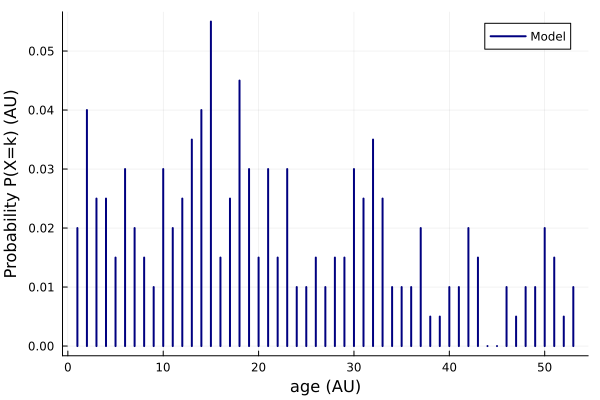

In [124]:
let
    plot(d₂, lw=2, c=:navy, label="Model")
    xlabel!("$(String(field_to_look_at)) (AU)", fontsize = 18);
    ylabel!("Probability P(X=k) (AU)", fontsize=18)
end

I'm curious. For the LOLs, let's compute the expectation of the discrete model and see how well it compares to its continuous analog. The same or different?

In [107]:
let
    data = dataset[:,field_to_look_at]; # Get the data for your field
    number_of_records = nrow(dataset); # how many total records?
    L = minimum(data);
    U = maximum(data);
    supportvector = range(L, stop=U, step=1) |> collect;
    p = params(d₂)[1]; # this gives the probability vector
    𝔼  = dot(p,supportvector); # compute the expectation

    println("Expectation: 𝔼(x) = $(𝔼)")
end

Expectation: 𝔼(x) = 38.85
